# 9. Recursive Neural Networks and Constituency Parsing

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture14-TreeRNNs.pdf
* https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
from IPython.display import Image, display
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from nltk.tree import Tree as nltkTree
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
# Borrowed from https://stackoverflow.com/questions/31779707/how-do-you-make-nltk-draw-trees-that-are-inline-in-ipython-jupyter

def draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 15 bold'
    tc['leaf_font'] = 'arial 15'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 50, 50)
    cf.print_to_file('tmp_tree_output.ps')
    cf.destroy()
    os.system('convert tmp_tree_output.ps tmp_tree_output.png')
    display(Image(filename='tmp_tree_output.png'))
    os.system('rm tmp_tree_output.ps tmp_tree_output.png')

## Data load and Preprocessing

### Stanford Sentiment Treebank(https://nlp.stanford.edu/sentiment/index.html)

In [10]:
sample = random.choice(open('../dataset/trees/train.txt', 'r', encoding='utf-8').readlines())
print(sample)

(3 (2 (1 Deflated) (2 (2 ending) (2 aside))) (4 (2 ,) (4 (2 there) (3 (3 (2 's) (3 (2 much) (2 (2 to) (3 (3 recommend) (2 (2 the) (2 film)))))) (2 .)))))



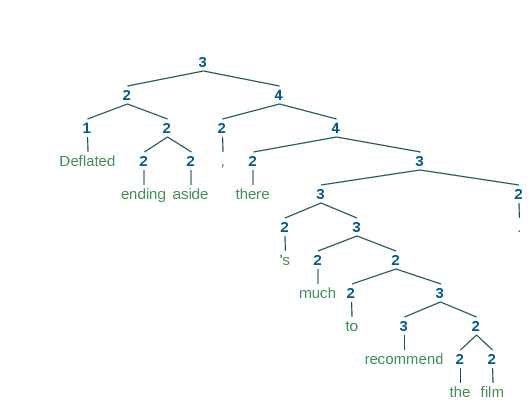

In [11]:
draw_nltk_tree(nltkTree.fromstring(sample))

### Tree Class 

borrowed code from https://github.com/bogatyy/cs224d/tree/master/assignment3

In [10]:
class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child
        # true if I am a leaf (could have probably derived this from if I have
        # a word)
        self.isLeaf = False
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words

def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]

def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)

    
def loadTrees(dataSet='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '../dataset/trees/%s.txt' % dataSet
    print("Loading %s trees.." % dataSet)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]

    return trees

In [11]:
train_data = loadTrees('train')

Loading train trees..


### Build Vocab 

In [12]:
vocab = list(set(flatten([t.get_words() for t in train_data])))

In [13]:
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

## Modeling 

<img src="../images/09.rntn-layer.png">
<center>borrowed image from https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf</center>

In [14]:
class RNTN(nn.Module):
    
    def __init__(self, word2index, hidden_size, output_size):
        super(RNTN,self).__init__()
        
        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
#         self.V = nn.ModuleList([nn.Linear(hidden_size*2,hidden_size*2) for _ in range(hidden_size)])
#         self.W = nn.Linear(hidden_size*2,hidden_size)
        self.V = nn.ParameterList([nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)) for _ in range(hidden_size)]) # Tensor
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size))
        self.b = nn.Parameter(torch.randn(1, hidden_size))
#         self.W_out = nn.Parameter(torch.randn(hidden_size,output_size))
        self.W_out = nn.Linear(hidden_size, output_size)
        
    def init_weight(self):
        nn.init.xavier_uniform(self.embed.state_dict()['weight'])
        nn.init.xavier_uniform(self.W_out.state_dict()['weight'])
        for param in self.V.parameters():
            nn.init.xavier_uniform(param)
        nn.init.xavier_uniform(self.W)
        self.b.data.fill_(0)
#         nn.init.xavier_uniform(self.W_out)
        
    def tree_propagation(self, node):
        
        recursive_tensor = OrderedDict()
        current = None
        if node.isLeaf:
            tensor = Variable(LongTensor([self.word2index[node.word]])) if node.word in self.word2index.keys() \
                          else Variable(LongTensor([self.word2index['<UNK>']]))
            current = self.embed(tensor) # 1xD
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))
            
            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], 1) # 1x2D
            xVx = [] 
            for i, v in enumerate(self.V):
#                 xVx.append(torch.matmul(v(concated),concated.transpose(0,1)))
                xVx.append(torch.matmul(torch.matmul(concated, v), concated.transpose(0, 1)))
            
            xVx = torch.cat(xVx, 1) # 1xD
#             Wx = self.W(concated)
            Wx = torch.matmul(concated, self.W) # 1xD

            current = F.tanh(xVx + Wx + self.b) # 1xD
        recursive_tensor[node] = current
        return recursive_tensor
        
    def forward(self, Trees, root_only=False):
        
        propagated = []
        if not isinstance(Trees, list):
            Trees = [Trees]
            
        for Tree in Trees:
            recursive_tensor = self.tree_propagation(Tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[Tree.root]
                propagated.append(recursive_tensor)
            else:
                recursive_tensor = [tensor for node,tensor in recursive_tensor.items()]
                propagated.extend(recursive_tensor)
        
        propagated = torch.cat(propagated) # (num_of_node in batch, D)
        
#         return F.log_softmax(propagated.matmul(self.W_out))
        return F.log_softmax(self.W_out(propagated),1)

## Training 

It takes for a while... It builds its computational graph dynamically. So Its computation is difficult to train with batch.

In [15]:
HIDDEN_SIZE = 30
ROOT_ONLY = False
BATCH_SIZE = 20
EPOCH = 20
LR = 0.01
LAMBDA = 1e-5
RESCHEDULED = False

In [18]:
model = RNTN(word2index, HIDDEN_SIZE,5)
model.init_weight()
if USE_CUDA:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [19]:
for epoch in range(EPOCH):
    losses = []
    
    # learning rate annealing
    if RESCHEDULED == False and epoch == EPOCH//2:
        LR *= 0.1
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=LAMBDA) # L2 norm
        RESCHEDULED = True
    
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        if ROOT_ONLY:
            labels = [tree.labels[-1] for tree in batch]
            labels = Variable(LongTensor(labels))
        else:
            labels = [tree.labels for tree in batch]
            labels = Variable(LongTensor(flatten(labels)))
        
        model.zero_grad()
        preds = model(batch, ROOT_ONLY)
        
        loss = loss_function(preds, labels)
        losses.append(loss.data.tolist()[0])
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('[%d/%d] mean_loss : %.2f' % (epoch, EPOCH, np.mean(losses)))
            losses = []
        

[0/20] mean_loss : 1.62
[0/20] mean_loss : 1.25
[0/20] mean_loss : 0.95
[0/20] mean_loss : 0.90
[0/20] mean_loss : 0.88
[1/20] mean_loss : 0.88
[1/20] mean_loss : 0.84
[1/20] mean_loss : 0.83
[1/20] mean_loss : 0.82
[1/20] mean_loss : 0.82
[2/20] mean_loss : 0.81
[2/20] mean_loss : 0.79
[2/20] mean_loss : 0.78
[2/20] mean_loss : 0.76
[2/20] mean_loss : 0.75
[3/20] mean_loss : 0.68
[3/20] mean_loss : 0.73
[3/20] mean_loss : 0.74
[3/20] mean_loss : 0.72
[3/20] mean_loss : 0.72
[4/20] mean_loss : 0.74
[4/20] mean_loss : 0.69
[4/20] mean_loss : 0.69
[4/20] mean_loss : 0.68
[4/20] mean_loss : 0.67
[5/20] mean_loss : 0.73
[5/20] mean_loss : 0.65
[5/20] mean_loss : 0.64
[5/20] mean_loss : 0.64
[5/20] mean_loss : 0.65
[6/20] mean_loss : 0.67
[6/20] mean_loss : 0.62
[6/20] mean_loss : 0.62
[6/20] mean_loss : 0.62
[6/20] mean_loss : 0.62
[7/20] mean_loss : 0.57
[7/20] mean_loss : 0.59
[7/20] mean_loss : 0.59
[7/20] mean_loss : 0.59
[7/20] mean_loss : 0.59
[8/20] mean_loss : 0.60
[8/20] mean_loss

The convergence of the model is unstable according to the initial values. I tried to 5~6 times for this.

## Test

In [20]:
test_data = loadTrees('test')

Loading test trees..


In [21]:
accuracy = 0
num_node = 0

### Fine-grained all

In paper, they acheived 80.2 accuracy. 

In [23]:
for test in test_data:
    model.zero_grad()
    preds = model(test, ROOT_ONLY)
    labels = test.labels[-1:] if ROOT_ONLY else test.labels
    for pred, label in zip(preds.max(1)[1].data.tolist(), labels):
        num_node += 1
        if pred == label:
            accuracy += 1

print(accuracy/num_node * 100)

79.33705899068254


## TODO 

* https://github.com/nearai/pytorch-tools # Dynamic batch using TensorFold

## Further topics 

* <a href="https://arxiv.org/pdf/1503.00075.pdf">Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks</a>
* <a href="https://arxiv.org/abs/1603.06021">A Fast Unified Model for Parsing and Sentence Understanding(SPINN)</a>
* <a href="https://devblogs.nvidia.com/parallelforall/recursive-neural-networks-pytorch/?utm_campaign=Revue%20newsletter&utm_medium=Newsletter&utm_source=revue">Posting about SPINN</a>